# Описание данных:

## Наборы данных:


1. **BASE.CSV** - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.


2. **TRAIN.CSV** - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из BASE.CSV который максимально похож на него (по мнению экспертов).


3. **VALIDATION.CSV** - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из BASE.CSV


4. **VALIDATION_ANSWER.CSV** - правильные ответы к VALIDATION.CSV

## Задача:

Разработать алгоритм, который для всех товаров из VALIDATION.CSV предложит несколько вариантов наиболее похожих товаров из BASE.CSV

## Оценка качества:

Используется метрика **accuracy@5** (предложение пяти соседий связанных с данным, и если хоть один правильный в validation_answer - присваивается один бал)

In [1]:
#conda install -c pytorch faiss-cpu=1.7.4 mkl=2021 blas=1.0=mkl

In [2]:
#conda install -c conda-forge faiss

In [3]:
#conda install -c conda-forge catboost

In [4]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler



from catboost import CatBoostClassifier
import faiss

In [5]:
dt_base = pd.read_csv('E:\\Мастерская 2\\base.csv')
dt_train = pd.read_csv('E:\\Мастерская 2\\train.csv')
dt_valid = pd.read_csv('E:\\Мастерская 2\\validation.csv')
dt_valid_ans = pd.read_csv('E:\\Мастерская 2\\validation_answer.csv')

In [6]:
all_list = [dt_base, dt_train,dt_valid,dt_valid_ans]
for i in all_list:
    display(i.head(), i.describe())
    print(i.isna().sum())

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1,1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2,2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3,3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4,4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,...,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950944e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297931e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807799e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381661e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244111e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057445e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395738e+02,2.147063e+02,9.877081e+01,1.269732e+02


Id    0
0     0
1     0
2     0
3     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 73, dtype: int64


,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,...,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,...,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,...,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,...,-101.504830,19.774804,-178.929470,-71.745018,66.560655,-14.144571,31.685548,100.589324,-1074.464888,-76.478591
50%,-85.273695,7.652854,-42.830246,-146.067445,112.260100,-73.364420,-511.837758,22.278989,123.087540,125.963340,...,-80.859640,36.711365,-151.576985,14.072663,67.813585,23.441363,72.880192,115.236635,-808.801696,-48.700929
75%,-67.330810,10.981191,-17.713690,-132.277745,143.760830,-53.699612,-201.116578,65.899595,127.541802,169.701005,...,-60.492451,53.919520,-124.436974,100.011024,69.058750,59.941065,114.469224,129.791085,-357.087323,-20.487869
max,14.585236,28.917845,128.108460,-60.751625,301.363600,51.849710,109.625188,288.171840,149.356200,392.827150,...,47.733450,145.667130,11.907364,185.095137,74.779884,266.493320,319.867520,201.761260,98.768233,126.191790


Id        0
0         0
1         0
2         0
3         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 74, dtype: int64


,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.302233,7.669724,-43.842474,-146.119797,111.635071,-73.273042,-441.396759,21.594242,123.077725,126.001062,...,-81.129311,36.778882,-152.341249,14.397762,67.788892,23.250779,73.114446,115.196935,-709.457021,-48.416276
std,25.777321,4.956990,39.138775,20.495541,47.751576,28.515740,279.242585,66.478048,6.504931,64.981697,...,30.691590,25.427103,41.246347,98.695231,1.844522,55.403862,62.056224,21.493081,405.665764,41.292843
min,-190.353330,-11.109877,-217.538420,-220.050890,-81.198990,-176.705030,-791.460243,-265.608430,96.218350,-135.667300,...,-215.152280,-66.265970,-337.632870,-157.593541,60.377728,-210.672800,-175.921780,25.271042,-1297.923999,-209.935760
25%,-103.231790,4.292425,-69.680916,-160.210287,79.101920,-92.789803,-740.620025,-21.804730,118.657689,82.311205,...,-101.690472,19.564135,-179.115082,-70.420034,66.546130,-13.863008,31.494840,100.538862,-1074.464888,-76.359190
50%,-85.296745,7.657888,-43.230835,-146.080365,111.959330,-73.579283,-513.922978,22.138012,123.062568,126.083595,...,-81.027250,36.414150,-151.426035,14.768218,67.800445,23.508739,72.152398,115.280990,-807.029697,-48.670001
75%,-67.422104,10.993900,-17.765821,-132.119278,143.903735,-53.861139,-202.572440,66.097697,127.538967,169.680500,...,-60.274745,53.888420,-124.400438,99.803923,69.040832,60.154775,114.317053,129.770215,-358.400478,-20.283335
max,14.427986,27.409784,134.859800,-57.381890,302.065370,50.255325,109.632035,279.468900,151.822560,392.827150,...,41.390480,141.025270,14.602035,185.094333,75.400475,251.288590,305.937530,201.599980,98.737079,111.831955


Id    0
0     0
1     0
2     0
3     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 73, dtype: int64


,Id,Expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base


,Id,Expected
count,100000,100000
unique,100000,91502
top,100000-query,210304-base
freq,1,7


Id          0
Expected    0
dtype: int64


In [7]:
eda_prew_train = dt_train[0:2000]
eda_prew_base = dt_base[0:2000]
eda_prew_valid = dt_valid[0:2000]

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>],
       [<Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
        <Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>,
        <Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
        <Axes: title={'center': '14'}>, <Axes: title={'center': '15'}>],
       [<Axes: title={'center': '16'}>, <Axes: title={'center': '17'}>,
        <Axes: title={'center': '18'}>, <Axes: title={'center': '19'}>,
        <Axes: title={'center': '20'}>, <Axes: title={'center': '21'}>,
        <Axes: title={'center': '22'}>, <Axes: title={'center': '23'}>],
       [<Axes: title={'center': '24'}>, <Axes: title={'center': '25'}>,
        <Axes: title={'center': '26'}>, <Axes: title={'center': '27'}>,

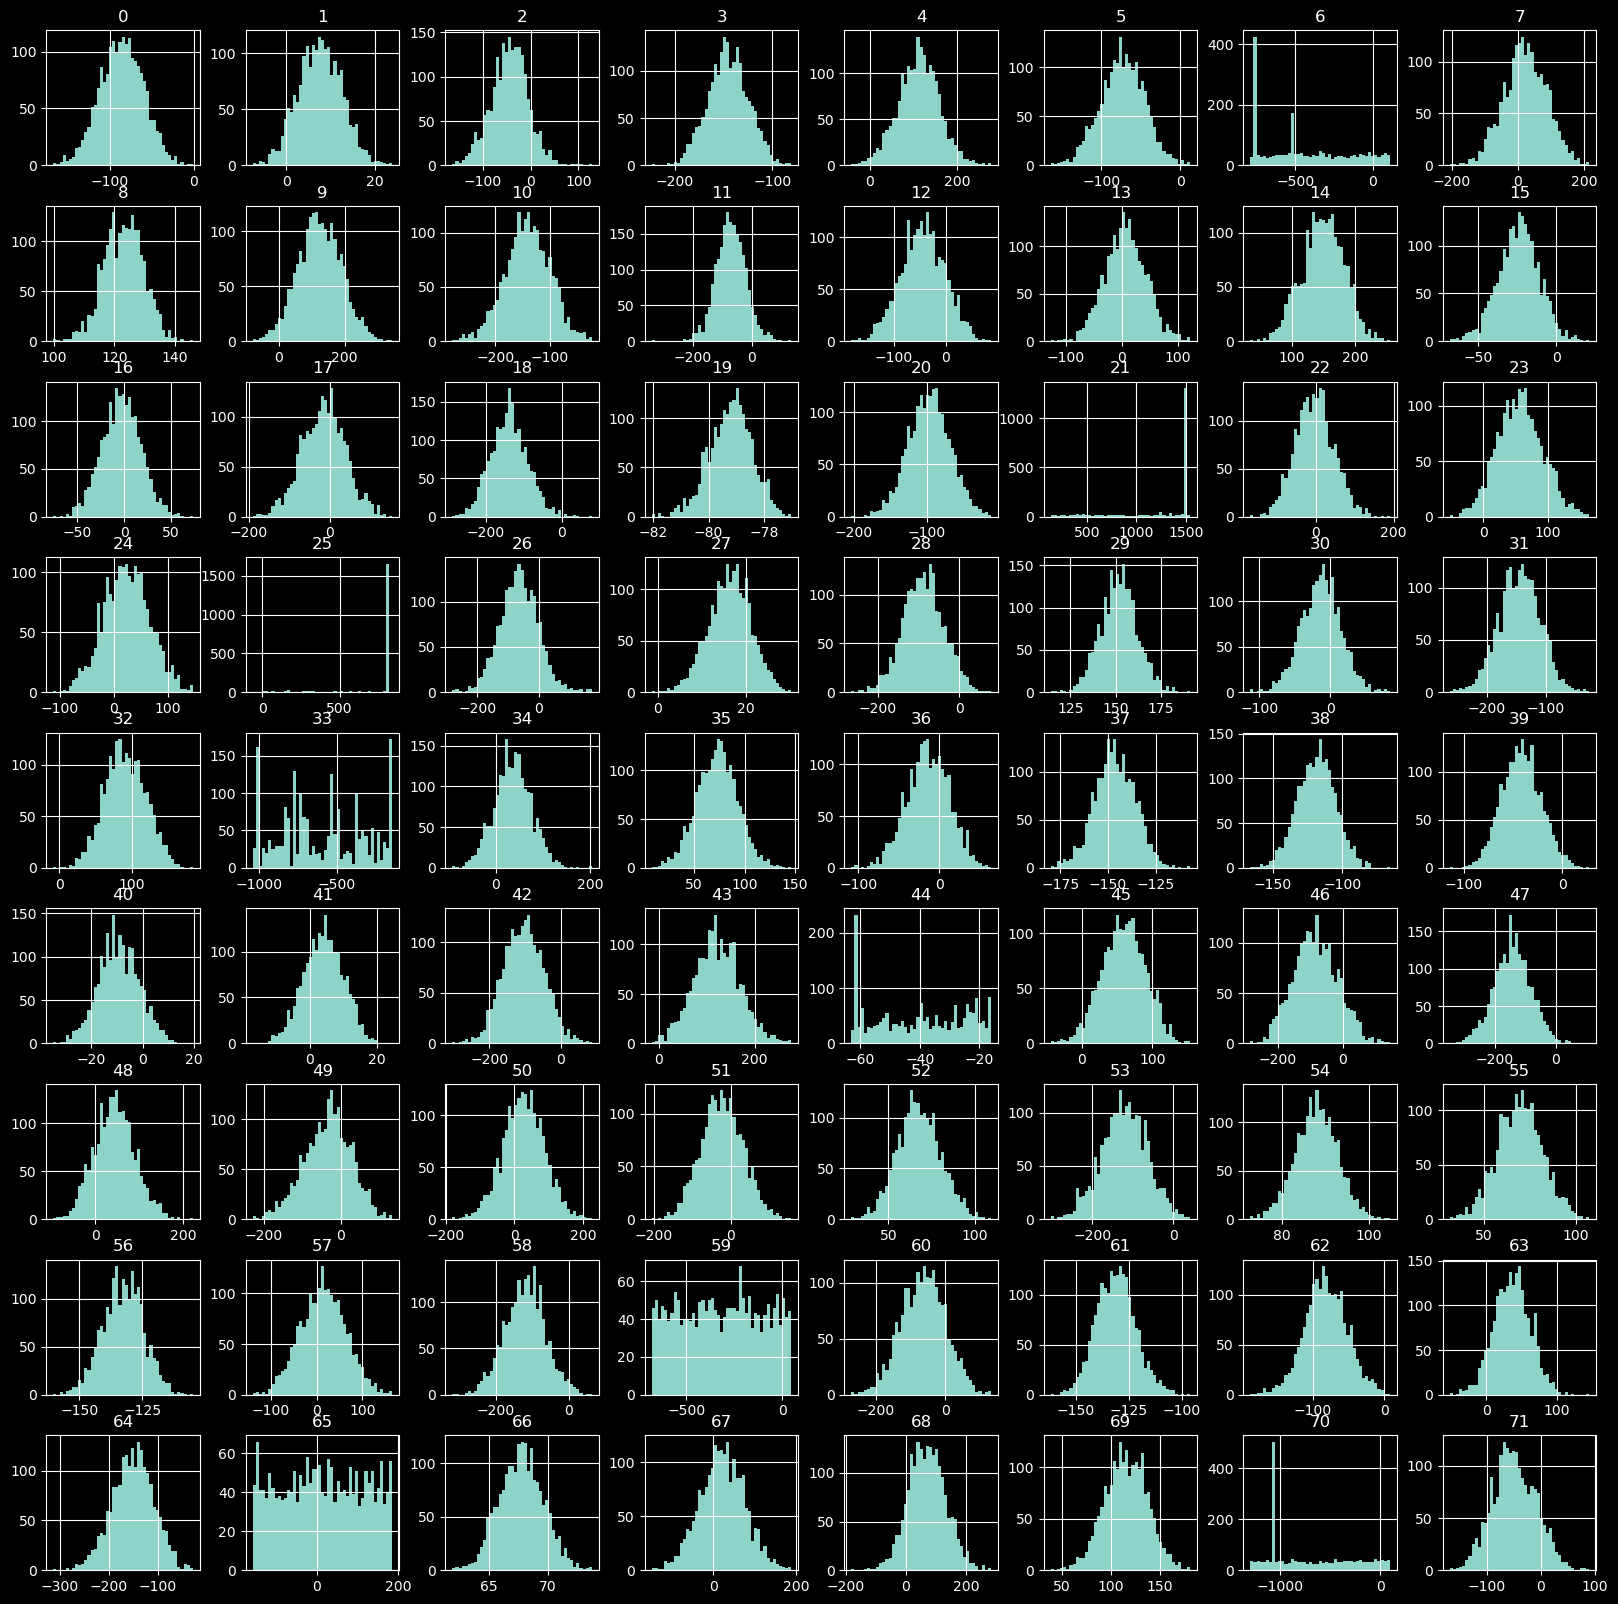

In [8]:
eda_prew_train.hist(figsize = [20,20], bins = 45)

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>],
       [<Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
        <Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>,
        <Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
        <Axes: title={'center': '14'}>, <Axes: title={'center': '15'}>],
       [<Axes: title={'center': '16'}>, <Axes: title={'center': '17'}>,
        <Axes: title={'center': '18'}>, <Axes: title={'center': '19'}>,
        <Axes: title={'center': '20'}>, <Axes: title={'center': '21'}>,
        <Axes: title={'center': '22'}>, <Axes: title={'center': '23'}>],
       [<Axes: title={'center': '24'}>, <Axes: title={'center': '25'}>,
        <Axes: title={'center': '26'}>, <Axes: title={'center': '27'}>,

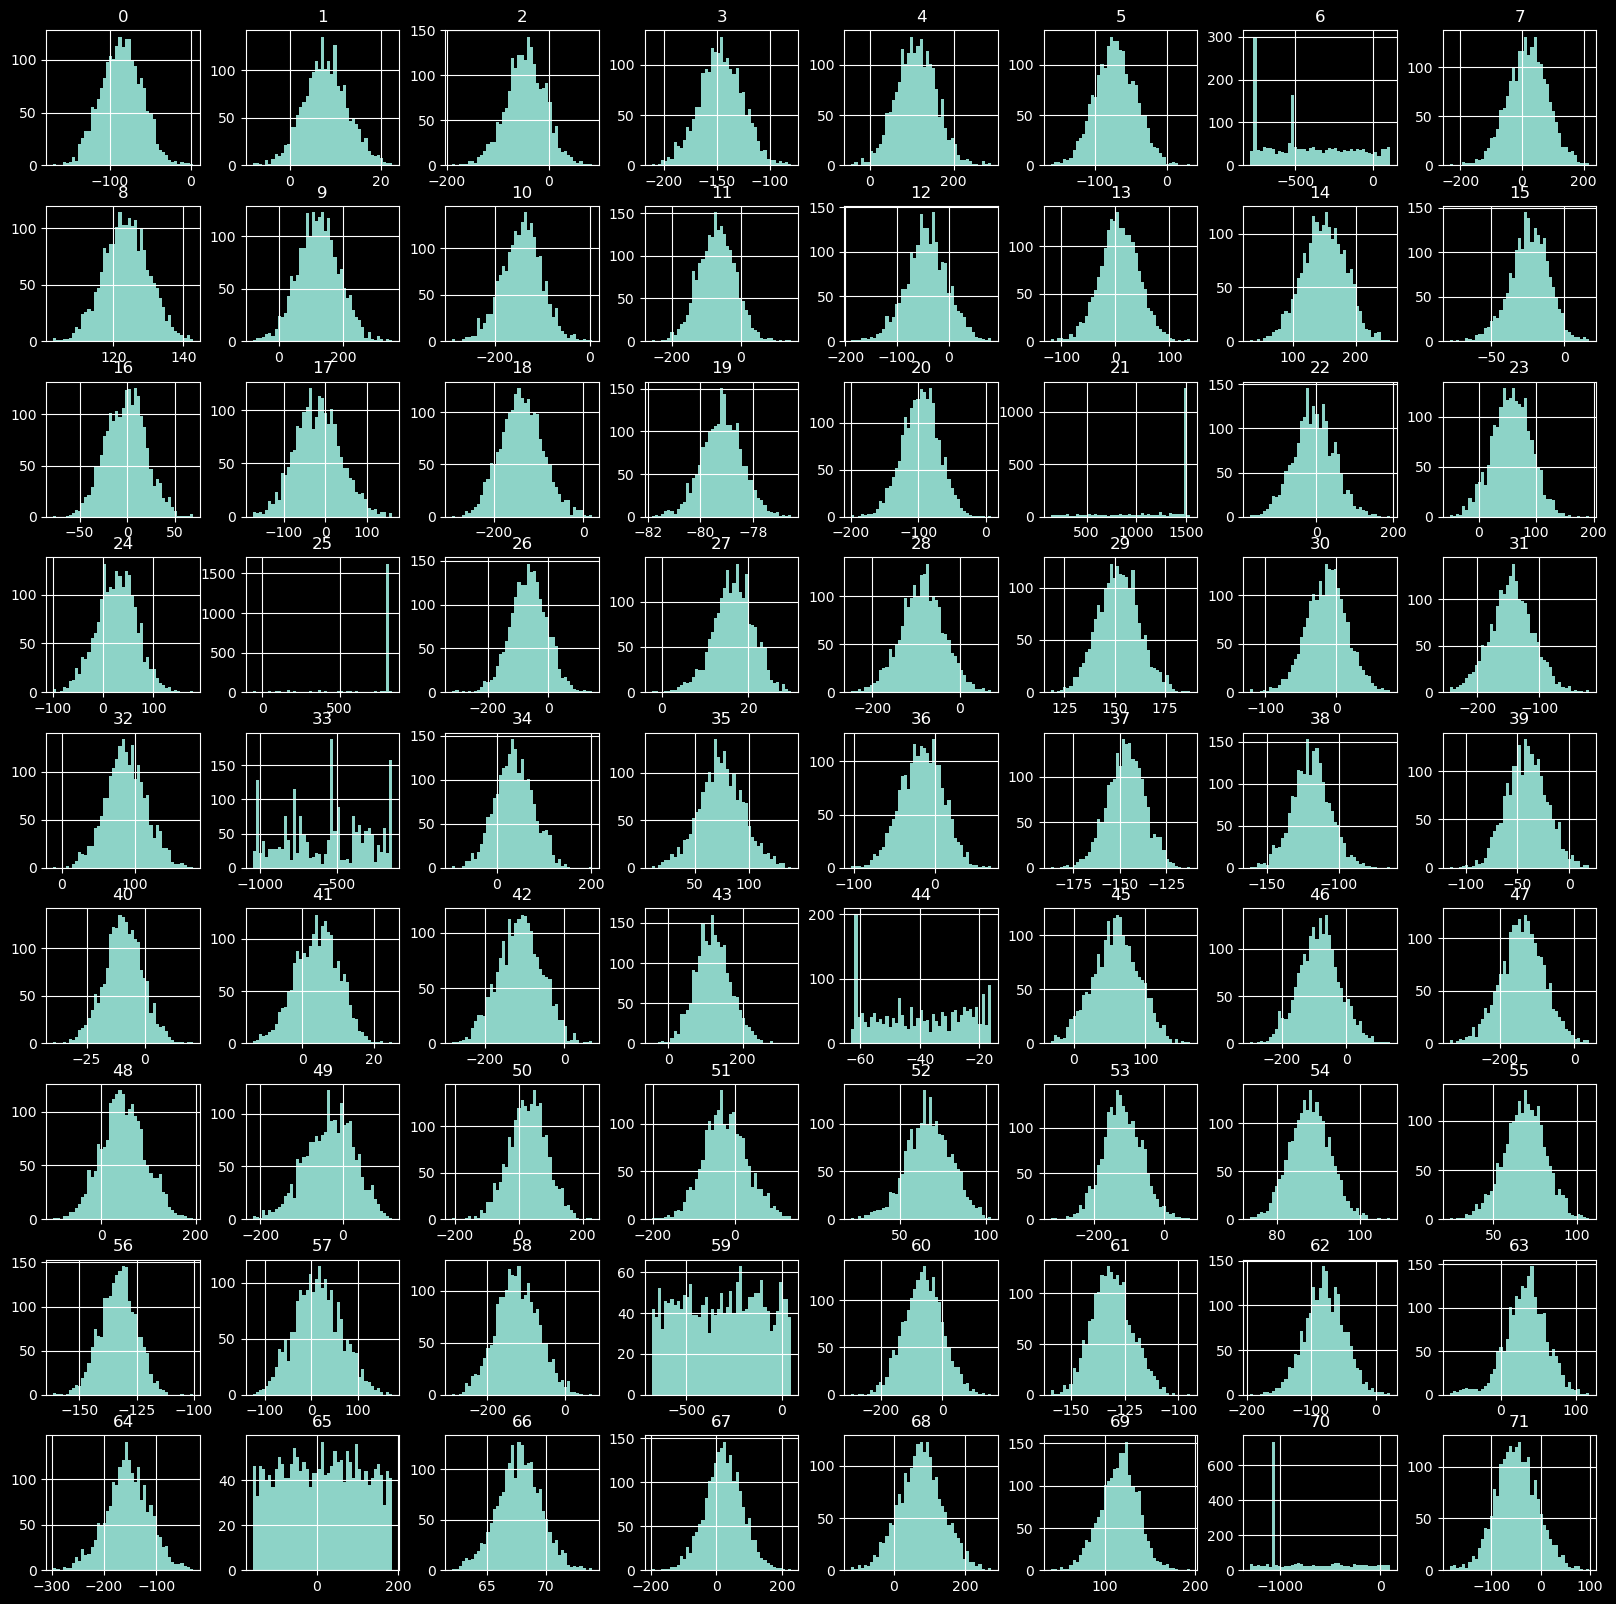

In [9]:
eda_prew_base.hist(figsize = [20,20], bins = 45)

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>],
       [<Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
        <Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>,
        <Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
        <Axes: title={'center': '14'}>, <Axes: title={'center': '15'}>],
       [<Axes: title={'center': '16'}>, <Axes: title={'center': '17'}>,
        <Axes: title={'center': '18'}>, <Axes: title={'center': '19'}>,
        <Axes: title={'center': '20'}>, <Axes: title={'center': '21'}>,
        <Axes: title={'center': '22'}>, <Axes: title={'center': '23'}>],
       [<Axes: title={'center': '24'}>, <Axes: title={'center': '25'}>,
        <Axes: title={'center': '26'}>, <Axes: title={'center': '27'}>,

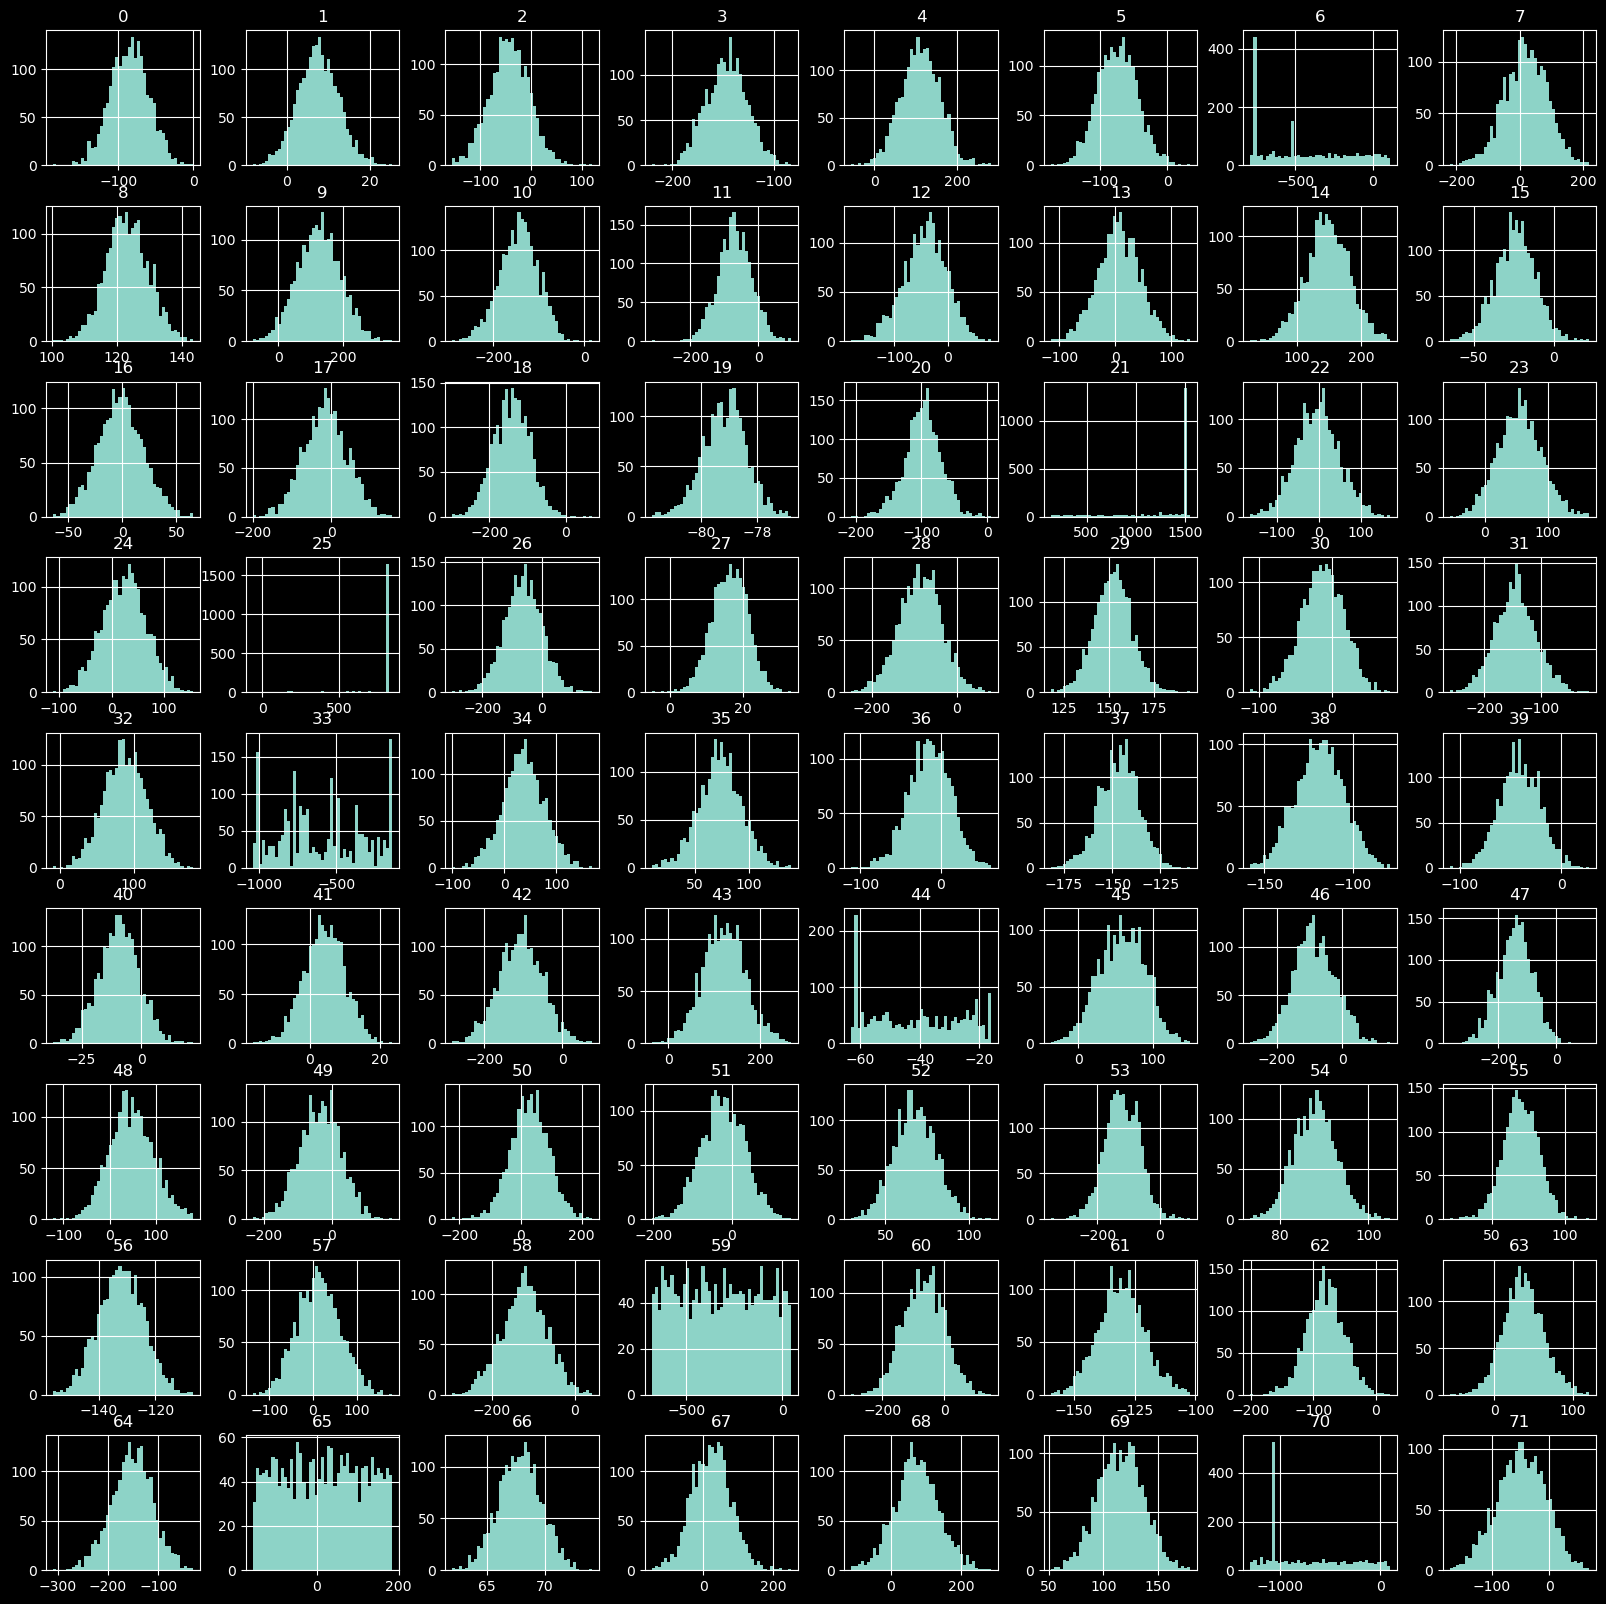

In [10]:
eda_prew_valid.hist(figsize = [20,20], bins = 45)

## Обработка блоков данных:


In [11]:

dt_base = pd.read_csv('E:\\Мастерская 2\\base.csv')
base_ind = dt_base['Id'].str.replace('-base','').astype(int)
base = dt_base.drop(columns = ['Id'])

**base_ind** - DataSeries где каждому числовому-индексу сопоставляется оригинальный индекс продукции


**base** - DataFrame со всеми признаками объекта 

In [12]:

dt_train = pd.read_csv('E:\\Мастерская 2\\train.csv')
train = dt_train
train['Id'] = train['Id'].str.replace('-query','')
train['Id'] = train['Id'].astype(int)
train = train.set_index('Id')
train_ans = train['Target'].str.replace('-base','').astype(int)
train = train.drop(columns = ['Target'], axis = 1)

**train** - обучающая выборка


**train_ans** - эталонные ответы самых похожих id из base_ind

## FAISS first iteration

**Проведем первичную пробу работоспособности FAISS на неизмененном наборе данных, отметив для себя точность**

### mono IndexFlatL2

**Качество работы обычного перебора всех данных**

In [13]:
index = faiss.IndexFlatL2(base.shape[1])
print(index.is_trained)
index.add(base)
print(index.ntotal)

True
2918139


In [14]:
topn = 100
index.nprobe = 1
vecs, idx = index.search(train.loc[:100], topn)

In [15]:
# Функция подсчета точности

def acur(I):
    cnt = 0
    for target, indx in zip(train_ans.values.tolist(), I.tolist()):
        cnt += int(target in [base_ind[r] for r in indx])
    print(cnt / len(idx) * 100, '%')

In [16]:
acur(idx)

19.801980198019802 %


### IndexFlatL2 + IndexIVFFlat

**Качество работы с использованем квантования по всем данным обучающего набора данных**

In [17]:
ifl2 = faiss.IndexFlatL2(base.shape[1])
topn = 100
ivffl = faiss.IndexIVFFlat(ifl2, base.shape[1],topn)
ivffl.is_trained

False

In [18]:
ivffl.train(np.ascontiguousarray(base.values[:60000, :]).astype('float32'))
ivffl.add(np.ascontiguousarray(base.values).astype('float32'))

In [19]:
#base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [20]:
topn = 100
vecs, idx = ivffl.search(train, topn)

In [21]:
acur(idx)

8.478 %


Функция для последующих тестов:

In [22]:
def faiss_test(train = train, base = base, topn = 100, nrob = 1):
    """index = faiss.IndexFlatL2(base.shape[1])
    print('Загрузка...')
    index.add(base)
    topn = topn
    index.nrobe = nrob
    vecs, idx = index.search(train.loc[:100], topn)
    print("Точность методом полного перебора(100 образцов):")
    acur(idx) """

    ifl2 = faiss.IndexFlatL2(base.shape[1])
    topn = topn
    ivffl = faiss.IndexIVFFlat(ifl2, base.shape[1],topn)
    ivffl.is_trained
    ivffl.train(np.ascontiguousarray(base.values[:60000, :]).astype('float32'))
    ivffl.add(np.ascontiguousarray(base.values).astype('float32'))
    topn = topn
    vecs, idx = ivffl.search(train, topn)
    print('Точность методом квантования(весь набор данных):')
    acur(idx)

## EDA 

**Перед переходом к ранджированию нам необходимо, чтобы в ранджируемых векторах было как можно больше верных ответов -> для улучшения работы faiss проведём обработку данных**

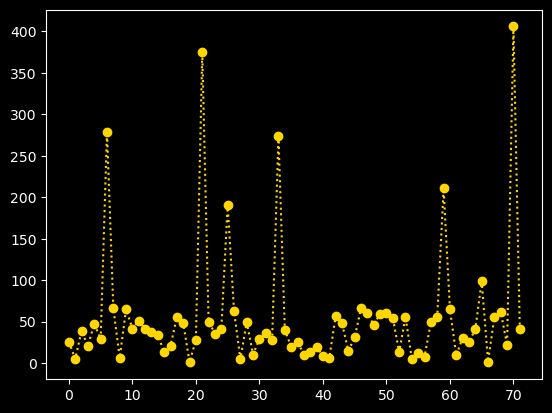

In [23]:
plt.plot(train.std().to_list(), ':o', color = 'gold')

**Стандартное отклонение четко показывает, что некоторые метрики растояний могут влиять на результат измерений гораздо больше остальных, что отразится на качестве модели** 

70    405.961084
21    375.123794
6     279.017550
33    273.294442
59    210.657513
25    191.052074
65     99.079597
46     66.055063
7      65.985214
60     64.913422
dtype: float64


array([[<Axes: title={'center': '70'}>, <Axes: title={'center': '21'}>,
        <Axes: title={'center': '6'}>],
       [<Axes: title={'center': '33'}>, <Axes: title={'center': '59'}>,
        <Axes: title={'center': '25'}>],
       [<Axes: title={'center': '65'}>, <Axes: title={'center': '46'}>,
        <Axes: title={'center': '7'}>],
       [<Axes: title={'center': '60'}>, <Axes: >, <Axes: >]], dtype=object)

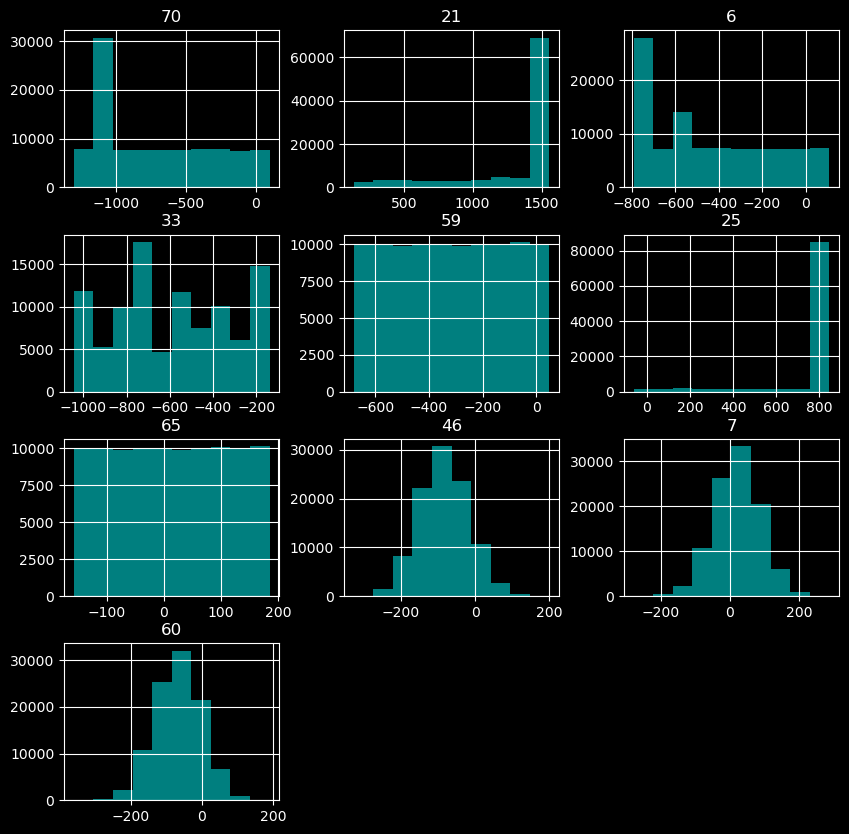

In [24]:
print(x_1 := train.std().sort_values(ascending = False)[:10])
x_i = x_1.index.to_list()
train.hist(column = x_i, figsize = [10,10], color = 'aqua', alpha = 0.5)

**Чемпионы по стандартному отклонению показывают отличные от нормального распределения графики**

In [25]:
strange_coulmns = ['70','21','6','33','59','25','65']

### Нормализация или стандартизация данных?

В общем случае, для уравнивания значимости данных под алгоритм  на подобие KNN мы будем ориентироваться на стандартизацию, подразумивая необходимость дальнейшего использования градиентного бустинга для ранжирования.

**StandardScaler**

**RobustScaler**

В частном случае, только под использование FAISS используем и Нормализацию, которая подразумивает сужение всех признаков в размерность[0,1]

**MinMaxScaler**

In [26]:
def reload_base():
    dt_base = pd.read_csv('E:\\Мастерская 2\\base.csv')
    base_ind = dt_base['Id'].str.replace('-base','').astype(int)
    base = dt_base.drop(columns = ['Id'])
    base_2 = base.drop(columns = strange_coulmns, axis = 1)
    return base, base_ind, base_2

In [27]:
def reload_train():
    dt_train = pd.read_csv('E:\\Мастерская 2\\train.csv')
    train = dt_train
    train['Id'] = train['Id'].str.replace('-query','')
    train['Id'] = train['Id'].astype(int)
    train = train.set_index('Id')
    train_ans = train['Target'].str.replace('-base','').astype(int)
    train = train.drop(columns = ['Target'], axis = 1)
    train_2 = train.drop(columns = strange_coulmns, axis = 1)
    return train, train_ans, train_2


## MinMaxScaler

In [28]:
scaler = MinMaxScaler()
base_mms = pd.DataFrame(scaler.fit_transform(base))
train_mms = pd.DataFrame(scaler.fit_transform(train))

In [29]:
display(base_mms)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,0.381859,0.571642,0.438010,0.627640,0.757360,0.394013,0.357783,0.538352,0.469686,0.590810,...,0.633174,0.524604,0.534391,0.242799,0.256558,0.416823,0.545929,0.500270,0.848552,0.469111
1,0.746236,0.621351,0.424642,0.364790,0.383926,0.462948,0.783921,0.413975,0.449440,0.613731,...,0.366170,0.534078,0.518351,0.184269,0.536499,0.469831,0.706106,0.508134,0.868505,0.472803
2,0.657219,0.462785,0.525830,0.547477,0.603128,0.413518,0.936658,0.566394,0.605642,0.562430,...,0.513529,0.554319,0.387979,0.831416,0.373813,0.546430,0.524094,0.506929,0.159996,0.549120
3,0.506591,0.409390,0.379717,0.262557,0.427874,0.563436,0.453097,0.417126,0.488577,0.515627,...,0.534011,0.338513,0.546449,0.349881,0.413110,0.387878,0.627437,0.511351,0.159996,0.434949
4,0.573456,0.466039,0.707574,0.507794,0.261972,0.366676,0.436974,0.539650,0.490865,0.475531,...,0.581915,0.598124,0.514326,0.710664,0.447884,0.420834,0.495083,0.599688,0.159996,0.641971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918134,0.336596,0.425297,0.694142,0.592360,0.741618,0.604632,0.181270,0.358866,0.547832,0.337893,...,0.535021,0.593121,0.429240,0.818730,0.370670,0.624231,0.277638,0.510248,0.488245,0.421230
2918135,0.411207,0.441687,0.543331,0.407907,0.515439,0.452774,0.748234,0.682920,0.607423,0.563050,...,0.535036,0.440699,0.695946,0.376453,0.566713,0.428392,0.329936,0.391021,0.159996,0.384391
2918136,0.463571,0.268420,0.420935,0.485329,0.599763,0.702098,0.035339,0.301215,0.535579,0.486574,...,0.586322,0.624007,0.488507,0.776344,0.560622,0.504243,0.501922,0.571973,0.159996,0.654406
2918137,0.509676,0.520538,0.511796,0.696138,0.347608,0.425530,0.286940,0.484700,0.556345,0.387578,...,0.476238,0.336040,0.475401,0.019220,0.562429,0.426698,0.548724,0.548384,0.159996,0.483362


In [30]:
faiss_test(train = train_mms, base = base_mms, topn = 100, nrob = 1)

Точность методом квантования(весь набор данных):
11.182 %


**Протестируем данные без выделяющихся столбцов:**

In [31]:
train_2 = train.drop(columns = strange_coulmns, axis = 1)
base_2 = base.drop(columns = strange_coulmns, axis = 1)

In [32]:
base_mms_2 = pd.DataFrame(scaler.fit_transform(base_2))
train_mms_2 = pd.DataFrame(scaler.fit_transform(train_2))

In [33]:
faiss_test(train = train_mms_2, base = base_mms_2, topn = 100, nrob = 1)

Точность методом квантования(весь набор данных):
55.054 %


## StandardScaler

In [34]:
train, train_ans, train_2 = reload_train()
base, base_ind, base_2 = reload_base()

In [35]:
stdsc = StandardScaler()
train_std = pd.DataFrame(stdsc.fit_transform(train))
base_std = pd.DataFrame(stdsc.fit_transform(base))

In [36]:
display(base_std)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,-1.159216,0.620350,-0.513723,1.398558,2.269043,-1.160385,-0.282884,0.373663,-0.435627,0.884544,...,1.189049,0.190524,0.073589,-0.894789,-2.262493,-0.510438,0.293004,-0.014051,1.781420,-0.312329
1,2.075715,1.060423,-0.652491,-1.002705,-1.157244,-0.500495,1.130652,-0.871900,-0.623903,1.098487,...,-1.272135,0.270119,-0.073569,-1.097493,0.225102,0.014491,1.711283,0.059848,1.853726,-0.281052
2,1.285417,-0.343342,0.397878,0.666228,0.853956,-0.973671,1.637293,0.654489,0.828686,0.619635,...,0.086191,0.440159,-1.269686,1.143739,-1.220546,0.773022,0.099669,0.048521,-0.713847,0.365623
3,-0.051852,-0.816047,-1.118829,-1.936660,-0.754014,0.461441,0.033281,-0.840347,-0.259958,0.182763,...,0.274980,-1.372853,0.184217,-0.523936,-0.871349,-0.797073,1.014714,0.090076,-0.713847,-0.601807
4,0.541780,-0.314538,2.284450,0.303705,-2.276181,-1.422075,-0.020200,0.386656,-0.238677,-0.191508,...,0.716557,0.808178,-0.110496,0.725544,-0.562342,-0.470720,-0.157210,0.920175,-0.713847,1.152406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918134,-1.561060,-0.675221,2.145022,1.076266,2.124613,0.855791,-0.868394,-1.423783,0.291078,-1.476259,...,0.284290,0.766146,-0.891135,1.099805,-1.248473,1.543466,-2.082561,0.079706,0.475699,-0.718053
2918135,-0.898663,-0.530123,0.579546,-0.608808,0.049398,-0.597886,1.012274,1.821418,0.845243,0.625420,...,0.284428,-0.514378,1.555805,-0.431911,0.493593,-0.395871,-1.619490,-1.040661,-0.713847,-1.030208
2918136,-0.433776,-2.064035,-0.690969,0.098481,0.823080,1.788798,-1.352459,-2.001122,0.177137,-0.088426,...,0.757178,1.025621,-0.347378,0.953011,0.439465,0.355254,-0.096658,0.659732,-0.713847,1.257774
2918137,-0.024465,0.167939,0.252204,2.024324,-1.490462,-0.858682,-0.517876,-0.163629,0.370246,-1.012485,...,-0.257554,-1.393629,-0.467622,-1.669100,0.455521,-0.412650,0.317753,0.438073,-0.713847,-0.191579


In [37]:
faiss_test(train = train_std, base = base_std, topn = 100, nrob =1)

Точность методом квантования(весь набор данных):
61.956 %


**Без выделяющихся столбцов:**

In [38]:
stdsc = StandardScaler()
train_std_2 = pd.DataFrame(stdsc.fit_transform(train_2))
base_std_2 = pd.DataFrame(stdsc.fit_transform(base_2))

In [39]:
faiss_test(train = train_std_2, base = base_std_2, topn = 100, nrob = 1)

Точность методом квантования(весь набор данных):
67.348 %


## RobustScaler

In [40]:
train, train_ans, train_2 = reload_train()
base, base_ind, base_2 = reload_base()

In [41]:
robust = RobustScaler()
train_rob = pd.DataFrame(robust.fit_transform(train))
base_rob = pd.DataFrame(robust.fit_transform(base))

In [42]:
display(base_rob)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,-0.853397,0.460538,-0.412746,1.049610,1.690895,-0.841724,-0.099159,0.273315,-0.350781,0.678173,...,0.886879,0.116154,0.041450,-0.515980,-1.696133,-0.389094,0.219288,-0.027103,1.691004,-0.218730
1,1.528277,0.782926,-0.520104,-0.743363,-0.875959,-0.364060,0.713246,-0.655240,-0.491795,0.839484,...,-0.976363,0.181517,-0.072084,-0.633299,0.158453,0.012873,1.279020,0.029052,1.740004,-0.195393
2,0.946431,-0.245443,0.292514,0.502795,0.630760,-0.706570,1.004428,0.482669,0.596147,0.478435,...,0.051959,0.321153,-0.994906,0.663859,-0.919326,0.593723,0.074829,0.020445,0.000000,0.287116
3,-0.038115,-0.591736,-0.880887,-1.440728,-0.573874,0.332242,0.082551,-0.631718,-0.219212,0.149039,...,0.194882,-1.167681,0.126802,-0.301341,-0.658988,-0.608587,0.758547,0.052023,0.000000,-0.434720
4,0.398938,-0.224341,1.752062,0.232106,-1.714228,-1.031150,0.051813,0.283002,-0.203272,-0.133156,...,0.529178,0.623368,-0.100573,0.421821,-0.428613,-0.358680,-0.117109,0.682816,0.000000,0.874164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918134,-1.149249,-0.488570,1.644194,0.808962,1.582692,0.617694,-0.435671,-1.066664,0.193496,-1.101842,...,0.201930,0.588851,-0.702848,0.638432,-0.940146,1.183695,-1.555723,0.044143,0.806137,-0.521456
2918135,-0.661569,-0.382274,0.433062,-0.449248,0.028014,-0.434557,0.645210,1.352604,0.608548,0.482798,...,0.202035,-0.462707,1.185003,-0.248080,0.358623,-0.301364,-1.209719,-0.807225,0.000000,-0.754367
2918136,-0.319302,-1.505986,-0.549873,0.078870,0.607630,1.293056,-0.713879,-1.497065,0.108158,-0.055434,...,0.559930,0.801931,-0.283332,0.553472,0.318268,0.273814,-0.071865,0.484904,0.000000,0.952783
2918137,-0.017952,0.129111,0.179814,1.516857,-1.125595,-0.623335,-0.234217,-0.127230,0.252791,-0.752162,...,-0.208273,-1.184742,-0.376102,-0.964128,0.330239,-0.314213,0.237781,0.316466,0.000000,-0.128634


In [43]:
faiss_test(train = train_rob, base = base_rob, nrob = 1, topn = 100)

Точность методом квантования(весь набор данных):
49.136 %


**Без выделяющихся столбцов:**

In [44]:
train_rob_2 = pd.DataFrame(robust.fit_transform(train_2))
base_rob_2 = pd.DataFrame(robust.fit_transform(base_2))

In [45]:
faiss_test(train = train_rob_2, base = base_rob_2, nrob = 1, topn = 100)

Точность методом квантования(весь набор данных):
67.586 %


## Выводы по преобразованиям:

* Наилучший показатель точности с рассчёта 1 эталонный точно есть в 100 похожих векторов -  67.5%.


* Отклоняющиеся от нормального столбцы вносят максимальный дисбаланс в работу с растоянием для модели Faiss. Так как 100% точность не достижима даже путем простого перебора - принято решение отказаться от этих показателей ввиду неоспоримой эффективности этого действия для работы модели.(Их возвращение оправдано только в случае иных алгоритмов, соревнующихся за большуюю точность и качество работы)

## Catboost

### сбор DataFrame

In [46]:
df_train = pd.read_csv('E:\\Мастерская 2\\train.csv')
df_train = df_train.rename(columns = {'Id':'train_id', "Target": "base_id"})
df_train_ind = df_train[['train_id','base_id']]
df_train_ind['default_id'] = df_train_ind.index
df_train = df_train.drop(columns = ['train_id', 'base_id'])

C:\Users\Маяк\AppData\Local\Temp\ipykernel_7584\3074099559.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_ind['default_id'] = df_train_ind.index


* df_train - признаки товаров
* df_train_ind - индекс выборки и ответов

In [47]:
def load_valid():
    df_valid = pd.read_csv('E:\\Мастерская 2\\validation.csv')
    df_valid_ans = pd.read_csv('E:\\Мастерская 2\\validation_answer.csv')
    df_valid_ans = df_valid_ans.rename(columns = {'Expected':'base_id','Id':'valid_id'})
    df_valid['default_id'] = df_valid.index
    df_valid_ans['default_id'] = df_valid_ans.index
    df_valid = df_valid.drop(columns = ['Id','default_id'])
    return df_valid, df_valid_ans

df_valid, df_valid_ans = load_valid()

* df_valid - признаки товаров
* df_valid_ans - индекс выборки и ответов

In [48]:
df_base = pd.read_csv('E:\\Мастерская 2\\base.csv')
df_base['default_id'] = df_base.index
df_base_ind = df_base[['Id','default_id']]
df_base_ind = df_base_ind.rename(columns = {'Id':'base_id'})
df_base = df_base.drop(columns = ['Id', 'default_id'])

* df_base - признаки товаров из всего набора
* df_base_ind - уникальный id товара

drop columns

In [49]:
df_train = df_train.drop(columns = strange_coulmns, axis = 1)
df_base = df_base.drop(columns = strange_coulmns, axis = 1)
df_valid = df_valid.drop(columns = strange_coulmns, axis = 1)

RobustScaler

In [50]:
robust = RobustScaler()
df_train_rob = pd.DataFrame(robust.fit_transform(df_train))
df_base_rob = pd.DataFrame(robust.fit_transform(df_base))
df_valid_rob = pd.DataFrame(robust.fit_transform(df_valid))

FAISS

**обучим faiss на этой страдии**

In [51]:
ifl2 = faiss.IndexFlatL2(df_base.shape[1])
topn = 100
ivffl = faiss.IndexIVFFlat(ifl2, df_base.shape[1],topn)
ivffl.is_trained
ivffl.train(np.ascontiguousarray(df_base.values[:60000, :]).astype('float32'))
ivffl.add(np.ascontiguousarray(df_base.values).astype('float32'))

def faiss_nn(inpu,vector_nn):
    topn = vector_nn
    distan, indx = ivffl.search(inpu, topn)
    return distan, indx

Чтобы вернуть base уникальные id обратно

In [52]:
df_base['base_id'] = df_base_ind['base_id']

**Обработка выборки**

In [53]:
def df_repeat(n=10, df_valid = df_valid, df_valid_ans = df_valid_ans, df_base = df_base, df_base_ind = df_base_ind):
    
    distan_valid,valid_v_index = faiss_nn(df_valid, n)

    # Запишим эталонные ответы в отдельный столбец
    df_valid['answer'] = df_valid_ans['base_id']
    
    # создаем массив индексов уникальных векторов размноженный в N раз.
    df_valid['valid_index'] = df_valid.index
    df_valid_indx = df_valid.loc[df_valid.index.repeat(n)]
    df_valid_indx = df_valid_indx['valid_index']   
    
    #увеличиваем набор данных в N раз
    df_valid_n = df_valid.loc[df_valid.index.repeat(n)]
    """faiss выдал нам список списков по n ближайших векторов в каждом,
    раскроем этот список и последовательно соединим c dataframe 
    размноженным в том же объеме"""
    
    vv=[]
    for i in range(len(valid_v_index)):
        for j in valid_v_index[i]:
            vv.append(j)

    df_valid_n['default_id'] = vv
    
    # по внешнему id объединяем предложенные faiss вектора и внутренний id-base

    df_valid_merge = df_valid_n.merge(df_base_ind, on = 'default_id', how = 'left') 
    df_valid_merge = df_valid_merge.merge(df_base, on = 'base_id', how = 'left')
    
    """При совпадении вектора эталонного ответа и предложенного faiss вектора добавим позитив в 
    новый столбец target"""

    df_valid_merge['target'] = df_valid_merge['answer']  ==  df_valid_merge['base_id']
    df_valid_merge['target'] = df_valid_merge['target'].astype(int)
    
        # удалим столбцы, надобность в которых отпадает 
    df_valid_merge_drops = df_valid_merge.loc[:,['default_id', 'base_id', 'answer']]
    df_valid_merge = df_valid_merge.drop(columns = ['default_id', 'base_id', 'answer'])
    
        # разделим признаки на Target и valid
    target_valid = df_valid_merge['target']
    features_valid = df_valid_merge.drop(columns = ['target'])
    print('В каком проценте эталонные образцы присутствуют для каждого уникального id товара, после использования faiss?:',
          '\n',target_valid.sum() / features_valid.shape[0] * n * 100, '%')
    return target_valid, features_valid, df_valid_indx

In [54]:
target_valid_100, features_valid_100, df_valid_indx_100 = df_repeat(n = 100)

В каком проценте эталонные образцы присутствуют для каждого уникального id товара, после использования faiss?: 
 65.957 %


In [55]:
faiss_ac = (target_valid_100.sum() / features_valid_100.shape[0] * 100 * 100)

In [56]:
target_train, features_train, train_df_indx = df_repeat(n = 10, df_valid = df_train, df_valid_ans = df_train_ind, df_base= df_base, df_base_ind = df_base_ind) 

В каком проценте эталонные образцы присутствуют для каждого уникального id товара, после использования faiss?: 
 62.4 %


## CatboostClassifier

In [57]:
cat = CatBoostClassifier(auto_class_weights = 'Balanced', verbose = 100)
cat.fit(features_train, target_train)

Learning rate set to 0.196759
0:	learn: 0.6669402	total: 467ms	remaining: 7m 46s
100:	learn: 0.3271963	total: 15.5s	remaining: 2m 17s
200:	learn: 0.2943723	total: 30s	remaining: 1m 59s
300:	learn: 0.2734690	total: 44.5s	remaining: 1m 43s
400:	learn: 0.2570700	total: 59.1s	remaining: 1m 28s
500:	learn: 0.2432626	total: 1m 13s	remaining: 1m 13s
600:	learn: 0.2312999	total: 1m 27s	remaining: 58.3s
700:	learn: 0.2201852	total: 1m 42s	remaining: 43.7s
800:	learn: 0.2107596	total: 1m 56s	remaining: 29s
900:	learn: 0.2020359	total: 2m 11s	remaining: 14.4s
999:	learn: 0.1938345	total: 2m 25s	remaining: 0us


**Точность ранжирования на top 5 из 100 похожих товаров:**

In [58]:
predictions = cat.predict_proba(features_valid_100)

predict = pd.DataFrame(predictions)
df_valid_indx_100 = df_valid_indx_100.reset_index()
accur = predict
accur['target'] = target_valid_100
accur['valid_ind'] = df_valid_indx_100['valid_index']


# Ранжируем вероятность позитивного класса для каждого уникального Id объекта 

accur['rank'] = accur.groupby('valid_ind')[1].rank(method = "first", ascending = True)
c = accur.query('rank > 95') 


print('Вероятность того, что один из 5 предложенных предметов будет эталонно отмечен экспертами:',
      ct := (c['target'].sum() / c.shape[0] * 5 * 100),'%')

Вероятность того, что один из 5 предложенных предметов будет эталонно отмечен экспертами: 59.85 %


**Точность модели CatBoostClassifier относительно точности выдаваемой faiss:**
* Т.к. faiss изначально предоставляет образцы не наполненные эталонными предсказаниями в числе 1 на n для КАЖДОГО уникального id, мы не можем описать точность самой модели CatBoost, поэтому для неё мы рассчитам иную точность:


In [59]:
catboost_acc = ct / faiss_ac * 100
print("Точность ранджирования модели CatBoost:", catboost_acc, '%')

Точность ранджирования модели CatBoost: 90.74093727731704 %


## Вывод:

**Исходя из показателей точности на итоговом тесте: совокупной работы моделей, индивидуальным показателям точности каждой:**

* Эффективность модели Faiss по подбору ближайших векторов, после предобработки данных, методом кластеризации векторов ~ 66%
* Эффективность модели CatBoostClassifier по ранджированию товаров ~ 90%


Основываясь на точности выше, целевая задача данного проекта - максимизировать эффективность отбора ближайших векторов моделью faiss, что даст максимальный прирост к качеству итоговых предложений. На чём стоит сосредоточиться в дальнейшей работе с данными.

**Точность итоговой модели, в данный момент, метрикой accuracy@5:**
* Стремится к 60% и точно составляет 59.85%

**Дальнейшее выполнение проекта:**
1. Углубленная обработка данных под faiss: 
* Тестирование удаления столбцов признаков с большими отклонениями.
* Уменьшение размерности с помощью методики главных компонент(РСА)
* Совмещение Нормализации и Стандартизации, с использованием большего разнообразия доступных методик.
* В случаё получения непреодолимых пределов по faiss - тест иных моделей быстрых поисков соседей.

2. Для улучшения второй модели:
* Возможно использование более сильной(наполненной) тренировочной выборки, полученной полным перебором по faiss, без кластеризации.
* Усиленный поиск гиперпараметров.
* Тестирование отличных от CatBoostClassifier моделей, вроде LightGBM